# Torch Runtime

In this tutorial, we introduce Torch Runtime, and show how to use it via the `TorchRuntimeClient` class in Qiskit Machine Learning.
Torch Runtime leverages Qiskit Runtime for 
hybrid quantum-classical machine learning based on a PyTorch `Module`. It allows training models or predicting the outputs with trained models significantly faster. We show how to use Torch Runtime with two simple examples for regression and classification tasks in the following.

## 1. Regression

First, we show how to use Torch Runtime via `TorchRuntimeClient` using the simple regression example. In the example, we will perform 
a regression task on a randomly generated dataset following a sin wave.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor, manual_seed, is_tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, Adam
from torch.utils.data import Dataset, DataLoader

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult


# Set seed for random generators
seed = 42
manual_seed(seed)
algorithm_globals.random_seed = seed


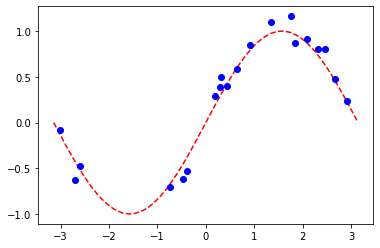

In [2]:
# Generate random dataset for the training
import matplotlib.pyplot as plt

np.random.seed(0)
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)
X = (ub - lb) * np.random.rand(num_samples, 1) + lb
y = f(X) + eps * (2 * np.random.rand(num_samples, 1) - 1)

plt.figure()
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()


`TorchRuntimeClient` requires a PyTorch `DataLoader` as an input for training/predicting. For that purpose, we create a custom torch dataset class.

In [3]:
# Create custom torch dataset class
class TorchDataset(Dataset):
    """Map-style dataset"""

    def __init__(self, X, y):
        self.X = Tensor(X).float()
        self.y = Tensor(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        import torch

        if torch.is_tensor(idx):
            idx = idx.tolist()

        X_i = self.X[idx]
        y_i = self.y[idx]

        # important: the dataset item must be returned as data,target
        return X_i, y_i


# Create a train loader
train_set = TorchDataset(X, y)
train_loader1 = DataLoader(train_set, batch_size=1, shuffle=False)


Create an instance of `TorchConnector` to wrap a QNN model and be able to use pytorch to train the model, then set up an optimizer and a loss function as usual.

In [4]:
from qiskit.circuit import Parameter

# Construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# Construct simple feature map
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# Construct QNN
qnn1 = TwoLayerQNN(1, feature_map, ansatz)
print(qnn1.operator)


initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights)

# Define optimizer and loss function
optimizer1 = Adam(model1.parameters(), lr=0.1)
loss_func1 = MSELoss(reduction="sum")


/Users/atsushi/github/terra-public/qiskit/opflow/primitive_ops/pauli_sum_op.py:359: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  Pauli((self.primitive.table.Z[0], self.primitive.table.X[0])),


ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
     ┌───────┐┌───────┐
  q: ┤ fm(x) ├┤ vf(y) ├
     └───────┘└───────┘
  )
])


Load a provider and specify a backend for the runtime service. 

In [5]:
# Set up a provider and backend
from qiskit import IBMQ

IBMQ.load_account()

provider = IBMQ.get_provider(project="default")  # replace by your runtime provider
backend = provider.get_backend("ibmq_qasm_simulator")  # select a backend that supports the runtime


Create a Torch Runtime Client instance with the model, the optimizer, and other configurations.

In [6]:
torch_runtime_client = TorchRuntimeClient(
    provider=provider,
    model=model1,
    optimizer=optimizer1,
    loss_func=loss_func1,
    epochs=5,
    backend=backend,
)


### Call `fit()` to train the model
Call the `fit` method in `TorchRuntimeClient` with the data loader to train the model.

In [ ]:
fit_result = torch_runtime_client.fit(train_loader=train_loader1)


You can access training result information by querying properties of the `fit_result` variable, that is an instance of the `TorchRuntimeResult` class. Also, model's parameters in `TorchRuntimeClient` are updated with trained ones. 

In [ ]:
print("id: ", fit_result.job_id)
print("execution time: ", fit_result.execution_time)
print("model_state_dict: ", torch_runtime_client.model.state_dict())


You can also query the `train_history` property, which is a list of dictionaries, each per epoch. In a dictionary you can find properties like: 
- `epoch`, epoch index
- `loss`, loss value at this epoch
- `forward_time`, time spent in the forward pass, in seconds
- `backward_time`, time spent in the backward pass, in seconds
- `epoch_time`, epoch time, in seconds."

#### Training with validation
Torch Runtime can also perform validation while training a model by passing a validation data loader to the `fit` method.

In [ ]:
# Create a validation dataloader
X_test = [[x] for x in np.linspace(lb, ub)]
y_test = [[y] for y in f(np.linspace(lb, ub))]
test_set = TorchDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


In [ ]:
torch_runtime_client = TorchRuntimeClient(
    provider=provider,
    model=model1,
    optimizer=optimizer1,
    loss_func=loss_func1,
    epochs=5,
    backend=backend,
)


In [ ]:
# Pass a train data loader and a validation data loader
fit_result = torch_runtime_client.fit(train_loader=train_loader1, val_loader=test_loader)


In [ ]:
print("id: ", fit_result.job_id)
print("execution time: ", fit_result.execution_time)

You can query the `val_history` property, which is a list of dictionaries for the validation processes, each per epoch. In a dictionary you can find the same properties as `train_history`.

### Call `predict()` to perform prediction
Call the `predict` method in `TorchRuntimeClient` with the data loader to perform prediction on the passed data using the trained model.

In [ ]:
predict_result = torch_runtime_client.predict(data_loader=test_loader)


In [ ]:
print("id: ", predict_result.job_id)
print("execution time: ", predict_result.execution_time)


In [ ]:
# Plot the original function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")

# Plot the training data
plt.plot(X, y, "bo")
# # Plot the prediction result
y_ = []
for output in predict_result.prediction:
    y_.append(output.item())
plt.plot(X_test, y_, "g-")

plt.show()


A red line, blue dots, and a green line on the plot show the original function, the training data, 
and a function constructed out of the predicted values, respectively. 

### `Call score()` to calculate a score
Call the `score` method in `TorchRuntimeClient` with the data loader to calculate a score,
for the trained model. You should pass either `"regression\"` or `"classification"` to the `score_func` argument to use one of the pre-defined scores functions. Also, you can pass a custom scoring function defined as:

```
def score_func(model_output, target): -> score: float\n",
```
where:,
- `model_output` are the values predicted by the model,
- `target` ground truth values,

Note that the result of the `score` call also contains predicted values that were calculated in the process of scoring the model.

In [ ]:
score_result = torch_runtime_client.score(data_loader=test_loader, score_func="regression")


In [ ]:
print("id: ", score_result.job_id)
print("execution time: ", score_result.execution_time)
print("score: ", score_result.score)


## 2. Classification

Second, we show how to perform a simple classification task using Torch Runtime. In the example, we will perform binary classification on a randomly generated dataset.

In [ ]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for CircuitQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for OplowQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()


In [ ]:
# Create custom torch dataset class
class TorchDataset(Dataset):
    """Map-style dataset"""

    def __init__(self, X, y):
        self.X = Tensor(X)
        self.y = Tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        import torch

        if torch.is_tensor(idx):
            idx = idx.tolist()

        X_i = self.X[idx]
        y_i = self.y[idx]

        # important: the dataset item must be returned as data,target
        return X_i, y_i


In [ ]:
y = y.reshape(20, 1)
train_set = TorchDataset(X, y)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)


In [ ]:
# Set up QNN
qnn = TwoLayerQNN(num_qubits=num_inputs)
print(qnn.operator)

# Set up PyTorch module
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn.num_weights) - 1)
model = TorchConnector(qnn, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)


In [ ]:
# Define optimizer and loss
optimizer = Adam(model.parameters(), lr=0.1)
loss_func = MSELoss(reduction="sum")


In [ ]:
torch_runtime_client = TorchRuntimeClient(
    provider=provider,
    model=model,
    optimizer=optimizer,
    loss_func=loss_func,
    epochs=5,
    backend=backend,
)


### Call `fit()` to train the model

In [ ]:
train_result = torch_runtime_client.fit(train_loader=train_loader, seed=42)


In [ ]:
print("id: ", fit_result.job_id)
print("execution time: ", fit_result.execution_time)


You can also query the `train_history` and the `val_history` properties.

### Call `predict()` to perform prediction

In [ ]:
# In this example, we use the same data loader for the prediction as well
predict_result = torch_runtime_client.predict(data_loader=train_loader)


In [ ]:
print("id: ", predict_result.job_id)
print("execution time: ", predict_result.execution_time)


In [ ]:
# Plot results
# red == wrongly classified

y_predict = []
for out in predict_result.prediction:
    y_predict += [np.sign(out.item())]
y_predict = np.array(y_predict)
y_check = [i[0] for i in y]

for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()


The red circles indicate wrongly classified data points.

### `score()` to calculate a score

In the example, we use the following custom scoring function to calculate a score. The scoring function returns 1, if the trained model successfully classified the input. Otherwise, it returns 0. An overall average is calculated in `score()` in the end.

In [ ]:
def score_func(out, target):
    from numpy import sign

    score = 0
    if sign(out.item()) == target.item():
        score = 1
    return score


In [ ]:
score_result = torch_runtime_client.score(data_loader=train_loader, score_func=score_func)


In [ ]:
print("id: ", score_result.job_id)
print("execution time: ", score_result.execution_time)
print("score: ", score_result.score)


## 3. How to use hooks in training
Qiskit Machine Learning offers a base hook class, `HookBase`. It is a base class for a hook that is a set of callback functions used in the training process. Users can implement their own hook classes from this base class to handle complicated callback processes. This structure provides high flexibility in the callback processes.
Each hook can implement 6 methods, and each method is called before/after the corresponding processes during training. The way they are called is demonstrated
in the following snippet:
```
    hook.before_train()
    for epoch in range(epochs):
        hook.before_epoch()
        for batch in train_loader:
            hook.before_step()
            train_step()
            hook.after_step()
            global_step += 1
        hook.after_epoch()
        epoch += 1
    hook.after_train()
```


 In the hook methods, users can access `TorchTrainer` via `self.trainer` to access more context properties(e.g., model, current iteration, or config). The following snippet describes available properties that might be useful for a hook.,

- TorchTrainer
  - `model`: A model to be trained.
  - `optimizer`: An optimizer used for the training.
  - `loss_func`: A loss function for the training.
  - `train_loader`: A PyTorch data loader object containing a training dataset.
  - `val_loader`: A PyTorch data loader object containing a validation dataset.
  - `max_epoch`: The maximum number of training epochs.
  - `log_period`: A logging period for a train history and a validation history. By default, there will be logs every epoch (`log_period`=1).
  - `start_epoch`: An initial epoch for warm-start training. By default, 0.
  - `epoch`: The current number of epochs.
  - `global_step`: The current number of steps.
  - `train_logger`: A logger for a training history. Use `train_logger.metrics` to access a list of logs. A log for each epoch is stored as a dictionary similar to `TorchRuntimeResult.train_history`
  - `val_logger`: A logger for a validation history. Logs are stored in the same way as train_logger.

 Users can pass a single hook instance or a list of hook instances to `hooks` argument.


The following example is a hook for early stopping. If the current loss is smaller than the threshold after an epoch, the training will be terminated. 

In [ ]:
from qiskit_machine_learning.runtime import HookBase

class StopHook(HookBase):
    """For early stopping"""

    def __init__(self, loss_threshold):
        self._loss_threshold = loss_threshold

    def after_epoch(self):
        # This function is called after each epoch
        current_loss = self.trainer.train_logger.metrics[-1]["loss"]
        print("current loss: ", current_loss)
        # If current loss is smaller than the threshold,
        # set the current number of the epoch to the maximum number of the epochs to stop the training
        if current_loss < self._loss_threshold:
            self.trainer.epoch = self.trainer.max_epochs


stop_hook = StopHook(loss_threshold=0.05)


In [ ]:
torch_runtime_client = TorchRuntimeClient(
    provider=provider,
    model=model1,
    optimizer=optimizer1,
    loss_func=loss_func1,
    epochs=5,
    backend=backend,
)


In [ ]:
fit_result = torch_runtime_client.fit(train_loader=train_loader1, hooks=stop_hook)


In [ ]:
print("id: ", fit_result.job_id)
print("execution time: ", fit_result.execution_time)
print("train history: ")
for epoch_result in fit_result.train_history:
    print("  epoch", epoch_result["epoch"], ": loss", epoch_result["loss"])


As we can see, training was interrupted after the second epoch despite we set the number of epochs to 5 in the `TorchRuntimeClient` configuration.

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright